In [9]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [10]:
# read the data
data = pd.read_csv("magic04.data", header = None)

num_columns = ['fLength', 'fWidth', 'fSize', 'fConc','fConc1',
                'fAsym','fM3Long','fM3Trans','fAlpha', 'fDist']

cat_columns = ['class']
# rename data's columns
data.columns = num_columns + cat_columns

In [11]:
# detect if there is a duplicated row or not
data.duplicated().sum()

np.int64(115)

In [12]:
# count how many number of g (gamma)  and h (hadrons)
data["class"].value_counts()

class
g    12332
h     6688
Name: count, dtype: int64

In [13]:
data = data.drop_duplicates()
data_num =  data.select_dtypes(include = [np.number])
data_cat = data.select_dtypes(include = object)
data_cat = (data_cat == 'g')

In [14]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
data_num_scaled = pd.DataFrame(std_scaler.fit_transform(data_num),
                               columns = num_columns)


In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict

train_data, test_data, train_target, test_target = train_test_split(
    data_num_scaled, data_cat, test_size=0.15, random_state=42, stratify=data_cat)

train_data, valid_data, train_target, valid_target = train_test_split(
    train_data, train_target, test_size=0.1765, random_state=42, stratify=train_target)

In [16]:
from imblearn.under_sampling import RandomUnderSampler

under_sample = RandomUnderSampler(random_state=42)
train_data_balanced, target_data_balanced = under_sample.fit_resample(train_data, train_target)

target_data_balanced = target_data_balanced.values.ravel()

SyntaxError: invalid syntax (__init__.py, line 1)

In [19]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_data_balanced, target_data_balanced)
train_pred = cross_val_predict(knn, train_data_balanced, target_data_balanced, cv = 10)

NameError: name 'train_data_balanced' is not defined

In [89]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, roc_curve ,roc_auc_score

cm = confusion_matrix(target_data_balanced, train_pred)
accuracy = accuracy_score(target_data_balanced, train_pred)
precision = precision_score(target_data_balanced, train_pred)
recall = recall_score(target_data_balanced, train_pred)
f1 = f1_score(target_data_balanced, train_pred)
clf_report = classification_report(target_data_balanced, train_pred)

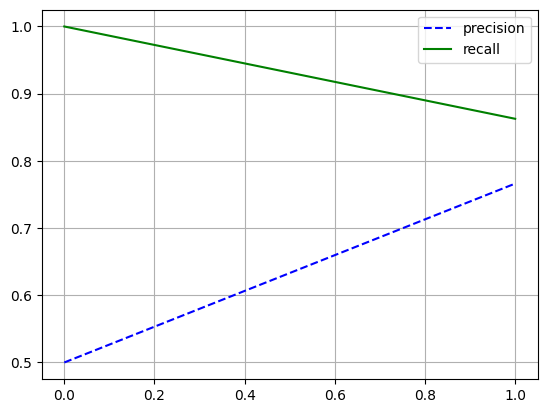

In [90]:
precisions, recalls, thresholds = precision_recall_curve(target_data_balanced, train_pred)
plt.plot(thresholds, precisions[:-1], "b--", label = "precision")
plt.plot(thresholds, recalls[:-1], "-g", label = "recall")
plt.grid(True)
plt.legend()
plt.show()

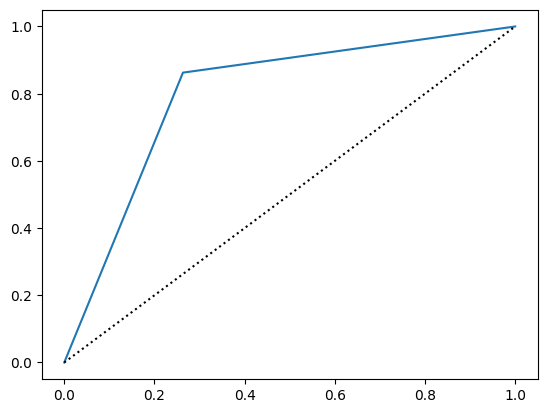

In [91]:
fpr, tpr, thresholds = roc_curve(target_data_balanced, train_pred)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],"k:")

In [92]:
roc_auc_score(target_data_balanced, train_pred)

np.float64(0.7997174527276679)

In [93]:
param_grid = {'n_neighbors': range(1, 25)}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, scoring="f1_weighted", cv=5)
grid_search.fit(valid_data, valid_target.values.ravel())
best_k = grid_search.best_params_['n_neighbors']

In [ ]:
def check_overfitting(model,x_train,y_train,x_vald,y_vald):
        y_tr_pred=model.predict(x_train)
        train_accuracy=accuracy_score(y_train,y_tr_pred)
        y_val_pred=model.predict(x_vald)
        valid_accuracy=accuracy_score(y_vald,y_val_pred)
        print("Model Metrics for CheckingOverfitting")
        print(f"Accuracy_ train {train_accuracy}")
        print(f"Accuracy_ validation {valid_accuracy}")
        return train_accuracy,valid_accuracy

In [94]:
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(train_data_balanced, target_data_balanced)

KNeighborsClassifier(n_neighbors=8)

In [95]:
train_pred = cross_val_predict(final_knn, train_data_balanced, target_data_balanced, cv = 3)
roc_auc_score(target_data_balanced, train_pred)

np.float64(0.8067811345359703)

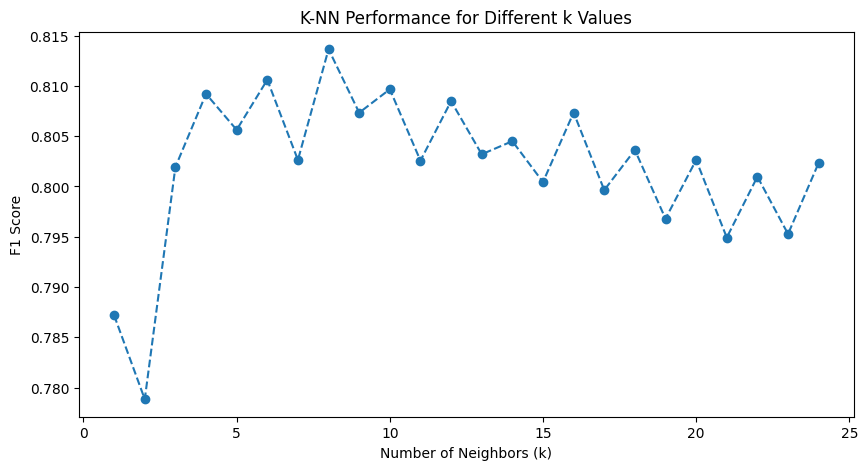

In [96]:
k_values = range(1, 25)
scores = grid_search.cv_results_['mean_test_score']

plt.figure(figsize=(10, 5))
plt.plot(k_values, scores, marker='o', linestyle='dashed')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('F1 Score')
plt.title('K-NN Performance for Different k Values')
plt.show()


In [97]:
test_pred = final_knn.predict(test_data)
test_cm = confusion_matrix(test_target, test_pred)
test_accuracy = accuracy_score(test_target, test_pred)
test_precision = precision_score(test_target, test_pred)
test_recall = recall_score(test_target, test_pred)
test_f1 = f1_score(test_target, test_pred)
test_clf_report = classification_report(test_target, test_pred)
"""
print("Confusion Matrix:\n", test_cm)
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 Score:", test_f1)
print("Classification Report:\n", test_clf_report)
"""

'\nprint("Confusion Matrix:\n", test_cm)\nprint("Accuracy:", test_accuracy)\nprint("Precision:", test_precision)\nprint("Recall:", test_recall)\nprint("F1 Score:", test_f1)\nprint("Classification Report:\n", test_clf_report)\n'